In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.5 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shap

In [ ]:
# Function to extract features
def extract_features(file_path, zip_file):
    with zip_file.open(file_path) as file:
        y, sr = librosa.load(file, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return S_DB, sr, y

# Load and preprocess the data
zip_path = '/content/drive/MyDrive/Bird sound classification data/archive (1).zip'
metadata_path = '/content/drive/MyDrive/Bird sound classification data/bird_songs_metadata.csv'
metadata = pd.read_csv(metadata_path)

In [ ]:
# Specific species extraction
species_of_interest = ['bewickii', 'polyglottos', 'migratorius', 'melodia', 'cardinalis']
metadata = metadata[metadata['species'].isin(species_of_interest)]

# Extracting features and labels
feature_list = []
labels = []

with zipfile.ZipFile(zip_path, 'r') as z:
    for index, row in metadata.iterrows():
        file_path = os.path.join('wavfiles', row['filename'])
        if file_path in z.namelist():
            S_DB, sr, y = extract_features(file_path, z)
            feature_list.append(np.mean(S_DB, axis=1))  # Mean over time
            labels.append(row['species'])

In [ ]:
# Prepare dataset
X_train, X_test, y_train, y_test = train_test_split(feature_list, labels, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train model
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_scaled, y_train_encoded)

RandomForestClassifier()

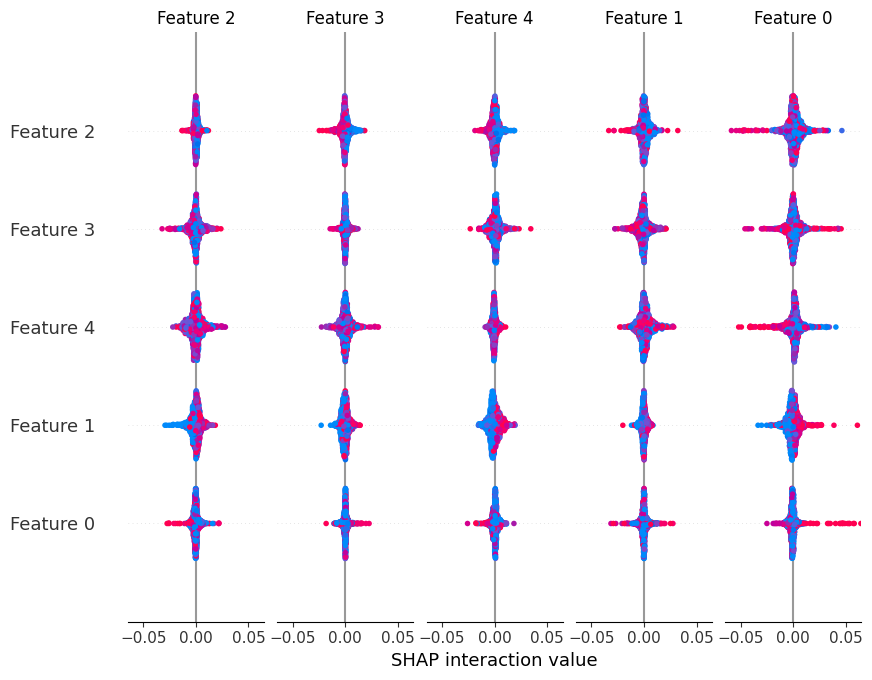

In [ ]:
# SHAP analysis
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP values
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

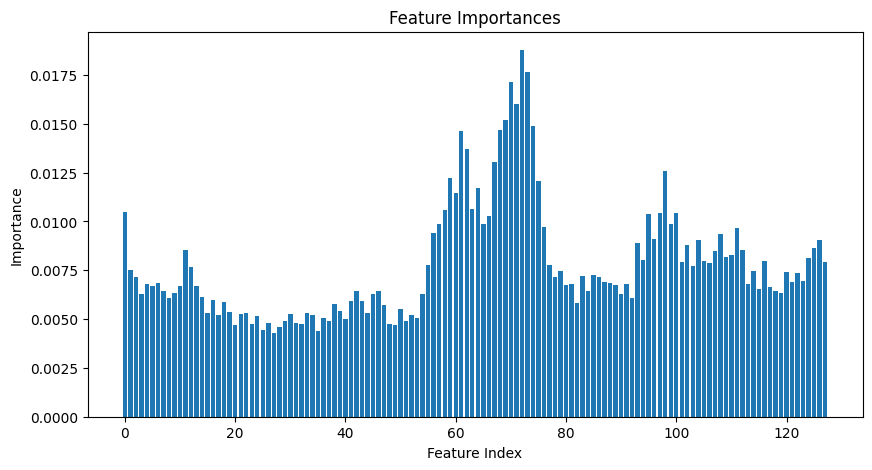

In [ ]:
# Plot feature importance
importances = rf.feature_importances_
plt.figure(figsize=(10, 5))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

In [ ]:
# Classification report
y_pred_rf = rf.predict(X_test_scaled)
print(classification_report(y_test_encoded, y_pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       193
           1       0.84      0.81      0.83       204
           2       0.80      0.86      0.83       243
           3       0.88      0.94      0.91       207
           4       0.90      0.84      0.87       238

    accuracy                           0.86      1085
   macro avg       0.86      0.85      0.86      1085
weighted avg       0.86      0.86      0.86      1085

